In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/simpleqa-measuring-short-form-factuality-in-llms/simple_qa_test_set.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
nlp = spacy.load("en_core_web_sm")
df = pd.read_csv('/kaggle/input/simpleqa-measuring-short-form-factuality-in-llms/simple_qa_test_set.csv')

In [7]:
df.head(2)
df.isnull().sum()

metadata    0
problem     0
answer      0
dtype: int64

In [8]:
#NLP
def extract_questions(text):
    doc = nlp(text)
    wh_word = text.split()[0].lower()
    num_tokens = len(doc)
    num_nouns = len([token for token in doc if token.pos_=='NOUN'])
    num_entities = len(doc.ents)
    has_year = any(token.like_num and "19" in token.text or "20" in token.text for token in doc)
    return wh_word, num_tokens, num_nouns, num_entities, has_year
    

In [9]:
def extract_metadata(meta):
    topic = meta.get("topic","Unknown")
    answer_type = meta.get("answer_type","Unknown")
    num_urls = len(meta.get("urls",[]))
    return topic,answer_type,num_urls

In [10]:
def extract_answer(ans):
    doc = nlp(ans)
    num_words = len(doc)
    num_proper_nouns = len([token for token in doc if token.pos == "PROPN"])
    return num_words,num_proper_nouns
    

In [11]:
def extract_metadata(meta):
    import ast
    if isinstance(meta, str):
        try:
            meta = ast.literal_eval(meta)  # Convert string to dict safely
        except (ValueError, SyntaxError):
            # If parsing fails, fallback to empty dict or default values
            meta = {}
    
    topic = meta.get("topic", "Unknown")
    answer_type = meta.get("answer_type", "Unknown")
    num_urls = len(meta.get("urls", []))
    return topic, answer_type, num_urls


In [12]:
features = []

for idx, row in df.iterrows():
    qf = extract_questions(row["problem"])
    mf = extract_metadata(row["metadata"])
    af = extract_answer(row["answer"])
    features.append(qf + mf + af)

# Create DataFrame
columns = [
    "wh_word", "q_tokens", "q_nouns", "q_entities", "q_has_year",
    "meta_topic", "meta_answer_type", "meta_num_urls",
    "ans_num_words", "ans_proper_nouns"
]
features_df = pd.DataFrame(features, columns=columns)

# Combine with original
df_combined = pd.concat([df, features_df], axis=1)


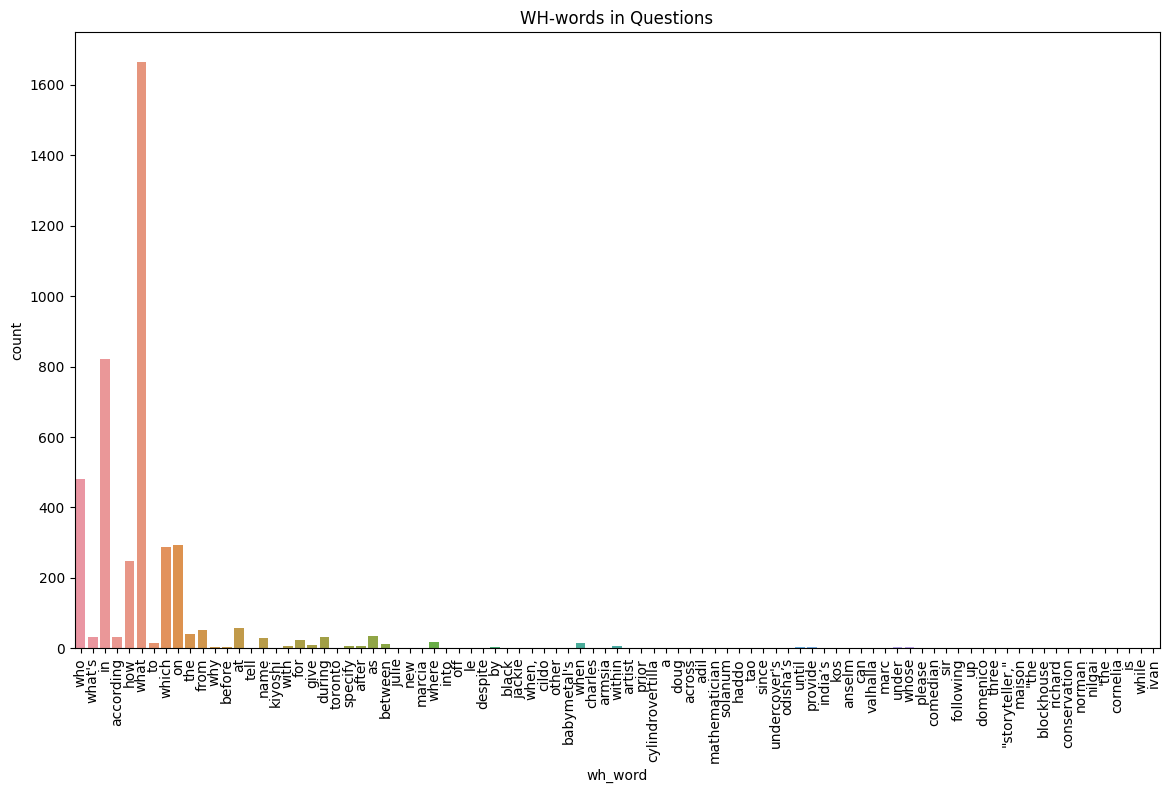

In [13]:
plt.figure(figsize=(14, 8))  # Increase width and height
sns.countplot(data=features_df, x="wh_word")
plt.xticks(rotation=90)
plt.title("WH-words in Questions")
plt.show()

In [14]:
#Using gpt 4.0
import pandas as pd
import random
df_combined = pd.concat([df, features_df], axis=1)

np.random.seed(42)
df_combined["label"] = np.random.choice([1, 0, -1], size=len(df_combined), p=[0.6, 0.3, 0.1])

In [15]:
filtered_df = df_combined[df_combined['label']!=-1]
columns = [
    "wh_word", "q_tokens", "q_nouns", "q_entities", "q_has_year",
    "meta_topic", "meta_answer_type", "meta_num_urls",
    "ans_num_words", "ans_proper_nouns"
]
encoded_df=pd.get_dummies(filtered_df[columns])

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    encoded_df, filtered_df["label"], test_size=0.2, random_state=42
)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score
clf = RandomForestClassifier(n_estimators = 1000,random_state = 42)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy: ",accuracy_score(y_pred,y_test))
print("Classification report:",classification_report(y_pred,y_test))

Accuracy:  0.5810983397190294
Classification report:               precision    recall  f1-score   support

           0       0.11      0.25      0.15       118
           1       0.83      0.64      0.72       665

    accuracy                           0.58       783
   macro avg       0.47      0.44      0.44       783
weighted avg       0.72      0.58      0.64       783



In [20]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_dt_pred = dt.predict(X_test)
print("Accuracy of Decision tree classifier: ",accuracy_score(y_dt_pred,y_test))
print("Classification report of decision tree classifier:",classification_report(y_dt_pred,y_test))

Accuracy of Decision tree classifier:  0.5236270753512133
Classification report of decision tree classifier:               precision    recall  f1-score   support

           0       0.32      0.31      0.32       279
           1       0.63      0.64      0.63       504

    accuracy                           0.52       783
   macro avg       0.48      0.48      0.48       783
weighted avg       0.52      0.52      0.52       783



**NOTES**
*100-dimensional data and used n_components=2, UMAP compressed your data into 2 dimensions

2025-05-28 14:38:38.309700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748443118.715532      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748443118.812328      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_35/3472583553.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

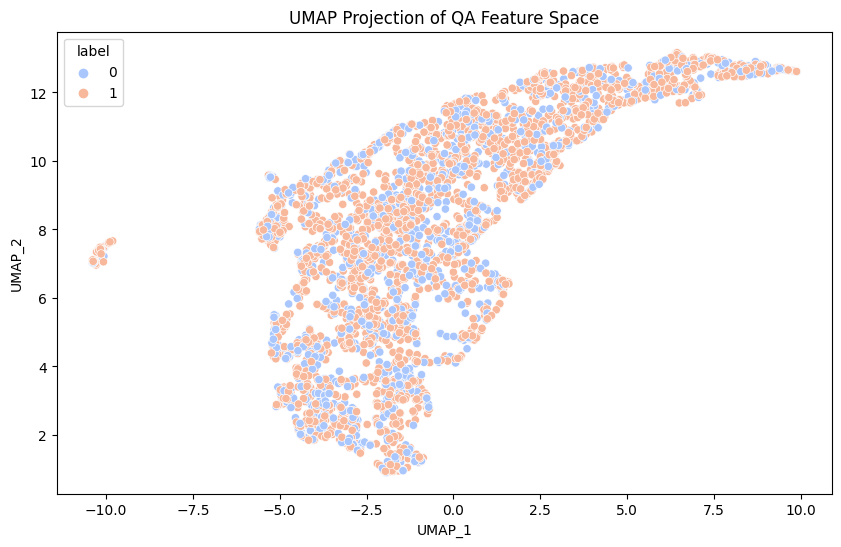

In [21]:
import umap.umap_ as umap
embedding = umap.UMAP(random_state=42).fit_transform(encoded_df)
filtered_df["UMAP_1"] = embedding[:, 0]
filtered_df["UMAP_2"] = embedding[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x="UMAP_1", y="UMAP_2", hue="label", palette="coolwarm")
plt.title("UMAP Projection of QA Feature Space")
plt.show()

In [24]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr= model.predict(X_test)

# Evaluate prediction accuracy
accuracy = accuracy_score(y_test, y_pred_lr)
print('Prediction Accuracy:', accuracy)


Prediction Accuracy: 0.6475095785440613


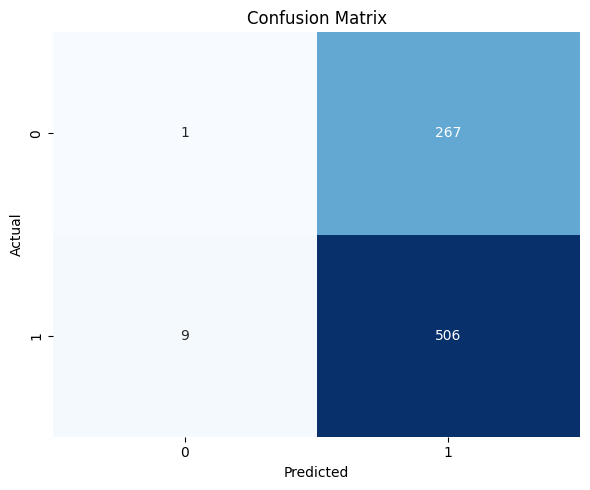

In [26]:
#Plot the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()